# KaXim tutorial

## Introduction
**KaXim** is a simulation tool for Expanded Kappa models (based on **Kappa Language** and KaSim).
This language allows the definition of **Agents** (the entities that compound and interact in the system) and **Rules** (the *events* that may happen with known probabilities in the system). These are the main elements of a Kappa model that allow to simulate its behaviour in time.

#### Basic Example
Lets take a look to the following example of a kappa simulation.

In [3]:
#the kappa model text of an exponential decay
kappa_decay = """
%params: 'N','decay-rate'

%agent: X()

'decay' X() ->   @ 'decay-rate'    #delete agent X

%init: 'N' X()

%obs: 'Agent X' X()
"""

#Create the kappa file and write the model in it
model = open("decay.xka","w")
model.write(kappa_decay)
model.close()

#run the simulation using KaXim 
X_0 = 20      #param for Kappa model
l = 1
!KaXim decay.xka -e {X_0} -p {min(X_0,200)} -d runs -o decay --params {X_0} {l}

#print output file
out = open("runs/decay.tsv")
print(out,out.read(),sep="\n")
out.close()

KaXim decay.xka -e 20 -p 20 -d runs -o decay --params 20 1 
Seed was randomized to value 2663605641.
%param: 'N' 20
%param: 'decay-rate' 1
========= No warnings =========
------------------------------------
Simulated time: 3.272983	Events: 20
Null-Events: 0 [0,0,0,0,0]
Null-actions = 0
------------------------------------
Simulation[0] finished.
Total running time: 0 seconds.
<_io.TextIOWrapper name='runs/decay.tsv' mode='r' encoding='UTF-8'>
#Time	Agent X
0	20
0.00717449	19
0.103752	18
0.108156	17
0.198714	16
0.221924	15
0.235482	14
0.2547	13
0.427296	12
0.492766	11
0.514038	10
0.584222	9
0.590862	8
0.769919	7
0.899308	6
1.0805	5
1.11654	4
1.14812	3
1.33775	2
2.19507	1
3.27298	0



The model is a simple exponential decay of the agent *X*, commonly expressed with the diferential equation
$$ \frac{dX}{dt} = -\lambda X$$
which solution is
$$ X(t) = X_0 e^{-\lambda t}$$

The simulation creates the output file "*runs/decay.tsv*" that contains its *time-trajectory*. We can use the KaXim's python plotting scripts to plot this file easily.

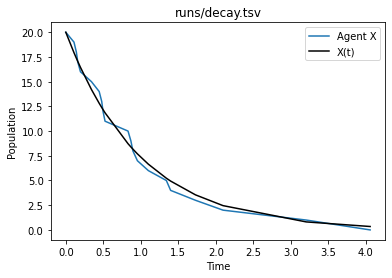

In [2]:
#plot the output file
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys 
import os
sys.path.append(os.path.relpath("../Py-scripts-kappa"))
import plotting_kappa as kappa

decay_plt = kappa.plot_file("runs/decay.tsv")

#plot the diferential eq. solution
time = decay_plt.lines[0].get_xdata()
plt.plot(time,X_0*np.exp(-time),'k-',label="X(t)")
plt.legend();

The **blue line** is the *time-trajectory* obtained using KaXim simulation.   
The **black line** is the solution to the differential equation in *exponential decay*.
##### Excercise:
Try increasing the value of $X_0$ to see how the plot looks.
### KaXim parameters
To see what are the **parameters** for KaXim, just run:

In [4]:
!KaXim --help

KaXim --help 
KaXim 2.1.04
Simple usage is 
$ KaXim ([-i] kappa_file)+ -t time [-p points] [-r runs]

Allowed options:
  -i [ --input-file ] arg Kappa files to read model (for backward compatibility
                          with KaSim/PISKa)
  -r [ --runs ] arg       Produce several trajectories, and make some 
                          statistical analysis at the end
  -e [ --events ] arg     Stop simulation at 'arg' events
  -t [ --time ] arg       Stop simulation at time 'arg' (arbitrary time unit)
  -p [ --points ] arg     Number of points in plot files
  -o [ --out ] arg        File names of data outputs. It can include a dot '.' 
                          to separate prefix and file type.
  -d [ --dir ] arg        Specifies directory where output files should be 
                          stored
  --params arg            Set values for each model %param, in the same order 
                          they are read from kappa model.
  -n [ --multinode ] arg  If true, equal agents w

We can see here the options we used to run the **exponential-decay** model.
- **input-file**: the address to the kappa-model file (decay.xka). Several kappa files can be given. The flag **-i** is optional.
- **events**: the max number of rule applications before stop running the simulation. This or **time** parameters must be given to KaXim to explicitly stop simulation. As the rule *'decay'* deletes agents, we use the same number of agents and events.
- **points**: The number of points (rows) to print to the output files. We plot a point to the output for each event in decay simulation.
- **directory**: the folder (*runs/*) to put all the output files.
- **out**: the (*prefix-*) name for the output file.
- **params**: Used to set values to the *%params* declared in the kappa-model. $init = 20$ is given from python to KaXim command line, and the model sets the *%param* **N** with this value.

To introduce later the parameter **--verbose**, lets make a new simple model where 2 agents connect and disconnect.

In [5]:
A_B_model = """
#Agent definition
%agent: A(i)
%agent: B(i)

#Rules
'A+B -> AB'  A(i),B(i) -> A(i!1),B(i!1) @ 1.0
'AB -> A+B'  A(i!1),B(i!1) -> A(i),B(i) @ 2.0

#Initialization
%init: 3 A()
%init: 3 B()
%init: 2 A(i!1),B(i!1)

#Vars
%var: 'A' A(i)
%var: 'B' B(i)

%obs: 'Free A & B' 'A'+'B'
%obs: 'Complex AB' A(i!1),B(i!1)
"""

There are 4 **main sections** in a kappa-model, here announced using '#' (a *commentary*):
1. **Agent Definition**: Every agent in the system has to be declared with a *name* (in this tutorial all agents are capitalized to avoid confusion with other entities) and an **interface** inside the parenthesis. *A* and *B* have simple *interfaces* containing only one **site**. See **-LINK-** for a detailed description about interfaces.
2. **Rules**: the model describes a system where two **species** (lets say *particles*) may interact to form a *connected-component* (first rule), and *disjoin* in a reverse process (second rule). Both rules include a name label, a *Left Hand Side* of reaction (**LHS**, the reactants), a *Right Hand Side* (**RHS**, the products) and a **rate**.
3. **Initialization**: Here the *initial quantities* of each *species* are specified. If the *agent's interface* is not fully specified, default values are used.
4. **Variables**: Associate a name with a quantity in the simulation. *Species concentrations* and *functions* can be defined as *Variables*. **Observables** (*%obs:*) allow to declare a *variable* that will be printed to the output-file.

These *sections* do not need to be written in any specific order, and they can even be mixed. Variables that depend on other variables values need to be written later.

Now we can introduce the **--verbose** level. This option will allow to understand what is KaXim doing during the simulation, and it will be very useful to understand why your models do not behave as you expected.  
As KaXim has very optimized functions, they lack of debugging and logging. The best way to test if a model works as it should is using **KaXim-Debug**. This version of KaXim is compiled with logging for most of its functions.

Just need to create a *kappa-file* with *AB* model and run it using **KaXim-Debug**:

In [6]:
model = open("A-B.xka","w")
model.write(A_B_model)
model.close()
!KaXim-Debug A-B.xka -p 10 -e 10 -d runs -o AB-output --verbose 3 --show-nodes -1

KaXim-Debug A-B.xka -p 10 -e 10 -d runs -o AB-output --verbose 3 --show-nodes -1 
Seed was randomized to value 2849920839.
========= The Environment =========
Components[3]
  [0] -> A(i)
  [1] -> B(i)
  [2] -> A(i!1),B(i!1)
Rules[2]
  [0] A+B -> AB ->
	BIND  agent[1]'s sites B(i) and A(i)
    1 new Injections will be produced.
      Changes in RHS-Agent[0] will produce new Injections of patterns:
	root-agent[0]	A(i!1),B(i!1)

  [1] AB -> A+B ->
	FREE  agent[0]'s site A.i from B.i
    2 new Injections will be produced.
      Changes in RHS-Agent[0] will produce new Injections of patterns:
	root-agent[0]	A(i)
      Changes in RHS-Agent[1] will produce new Injections of patterns:
	root-agent[0]	B(i)

-----------------------------
========= No warnings =========
========= Simulation[0] =========
StateGraph[10] -> {
  [0] A(i)
  [1] A(i)
  [2] A(i)
  [3] B(i)
  [4] B(i)
  [5] B(i)
  [6] A(i!(7))
  [7] B(i!(6))
  [8] A(i!(9))
  [9] B(i!(8))
}
Active Injections -> {
	(0)	3 injs of A(i)
	(1)	3

As the **--verbose** level increase, you will see more logging (max is 3). **--show-nodes** is used to limit the amount of *agent-nodes* when the simulation state is printed.
The first output you will see is the **seed value**. Every time you run a simulation, the seed will be *randomized* and the results will be different. To avoid this, choose a seed value using the parameter **--seed**.  
The **Environment** will be printed if *--verbose value > 0*.
- **Connected-Components** (**CC**) are the **species** of the model: sets of 1 or more connected *agent-patterns* that can be *matched* with *agent-nodes* in the *state-graph* of the simulation. These *matches* are called **Injections**, and are stored during simulation. Keep calm, this will be explained in more detail later.
- **Rules** are decomposed to the **actions** that they *apply*. Later we will see how these actions are extracted from solving the *differences* between **LHS** and **RHS**. Rule applicactions also have consequences: they produce *injections* which are listed after actions.

The warnings of the same kind will be printed up to 2 times.  
Later we have the simulation initial state printed:
- **StateGraph[nodes]**: the *agent-nodes* in the simulation. Binds have the id of the target agent.
- **Active Injections**: the matches [*CC -> agent-node*] found in StateGraph.
- **Active Rules**: The *non-zero reactivity* rules and their *reactivites* (binary and unary).
- **Counter**: All the quantities that will be incresing during the simulation.

Then KaXim starts running the simulation and get the events logging. Every event log include: event number, event *timing*, *total reactivity* before event application, rule to apply, id of (*root-nodes* of) CCs that will be modified and the list of actions applied.  
Finally it prints the final simulation state and the seconds it takes to produce the simulation.


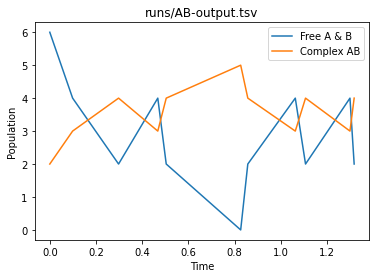

In [7]:
kappa.plot_file("runs/AB-output.tsv");

##### Excercise: 
Run the decay model using KaXim-Debug and --verbose 3.

#### Statistics
KaXim is based in the *Stochastic Simulation Algorithm* (**SSA**), a method that generates a *feasible* solution of a stochastic equation system. This solution is a statistically correct *time-trajectory* of the system, obtained by applying every event explicitly. Therefore, most of the systems will need several simulations and some statistical analysis. The KaXim parameter **--runs N** allows to produce **N** *time-trajectories* at once, using **OpenMP** libraries to take advantage from parallel architecture. The Kappa variable [ID] can be used in Kappa models to obtain the simulation *Id*, from 0 to **N**. 

A typical system where stochasticity plays an important role is the **Predator-Prey** interaction. These models are commonly studied using the *Lotka-Volterra* equations, a deterministic method useful to determine periods and size of oscilations, but incapable to show extintions.

Look at the following example of a *predator-prey* model:

KaXim Pred-Prey.xka -t 30 -e 10000 -p 100 -d runs -o pp --params 0.01 1.0 1.0 
Seed was randomized to value 652259558.
%param: 'Pred-feed rate' 0.01
%param: 'Prey-replicate rate' 1
%param: 'Pred-die rate' 1
========= Warnings =========
Max-Time option will be used to plot output points instead of Max-Events.
------------------------------------
Simulated time: 24.849767	Events: 10000
Null-Events: 0 [0,0,0,0,0]
Null-actions = 0
------------------------------------
Simulation[0] finished.
Total running time: 0 seconds.


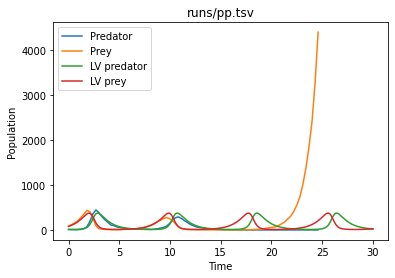

In [10]:
pred_prey_model = """
%agent: Pred()
%agent: Prey()

%params: 'Pred-feed rate','Prey-replicate rate','Pred-die rate'

%var: 'Pred-init' 10*(1+2*[ID])
%const: 'Prey-init' 80

'Pred-feed' Pred(),Prey() -> Pred(),Pred() @ 'Pred-feed rate'
'Prey-replicate' Prey() -> Prey(),Prey() @ 'Prey-replicate rate'
'Pred-die' Pred() ->  @ 'Pred-die rate'

%init: 'Pred-init' Pred()
%init: 'Prey-init' Prey()

%obs: 'Predator' Pred()
%obs: 'Prey' Prey()
"""

model = open("Pred-Prey.xka","w")
model.write(pred_prey_model)
model.close()

pred_feed = 0.01
prey_rep = 1.0
pred_die = 1.0

!KaXim Pred-Prey.xka -t 30 -e 10000 -p 100 -d runs -o pp --params {pred_feed} {prey_rep} {pred_die}
kappa.plot_file("runs/pp.tsv");

### Plotting Lotka-Volterra solution
from scipy.integrate import odeint
def df_dt(x, t, a, b, c, d):
    """Función del sistema en forma canónica"""
    dx = a * x[0] - b * x[0] * x[1]
    dy = - c * x[1] + d * x[0] * x[1]
    return np.array([dx, dy])
# Params
a = prey_rep
b = pred_feed
c = pred_die
d = pred_feed
# Init
init = np.array([80, 10])
t = np.linspace(0, 30, 200)
sol = odeint(df_dt, init, t, args=(a, b, c, d))
plt.plot(t, sol[:, 1], label='LV predator')
plt.plot(t, sol[:, 0], label='LV prey')
plt.legend();

The plot shows the curves for Predator and Prey populations obtained from *stochastic simulation* and *Lotka-Volterra equations*. If you run the simulation several times you will see *extintions* of both species (preys die first, then predators have no food) or only the predator (and preys growing exponentially).

Lets see how KaXim runs several simulation at once!

KaXim Pred-Prey.xka -t 30 -e 10000 -p 100 -d runs -o pp -r 9 --params 0.01 1.0 1.0 
Seed was randomized to value 3112141200.
%param: 'Pred-feed rate' 0.01
%param: 'Prey-replicate rate' 1
%param: 'Pred-die rate' 1
========= Warnings =========
Max-Time option will be used to plot output points instead of Max-Events.
------------------------------------
Simulated time: inf	Events: 7562
Null-Events: 0 [0,0,0,0,0]
Null-actions = 0
------------------------------------
Simulation[7] finished.
------------------------------------
Simulated time: inf	Events: 7407
Null-Events: 0 [0,0,0,0,0]
Null-actions = 0
------------------------------------
Simulation[0] finished.
------------------------------------
Simulated time: 30.000024	Events: 8834
Null-Events: 0 [0,0,0,0,0]
Null-actions = 0
------------------------------------
Simulation[2] finished.
------------------------------------
Simulated time: 30.001896	Events: 8851
Null-Events: 0 [0,0,0,0,0]
Null-actions = 0
---------------------------------

<IPython.core.display.Javascript object>


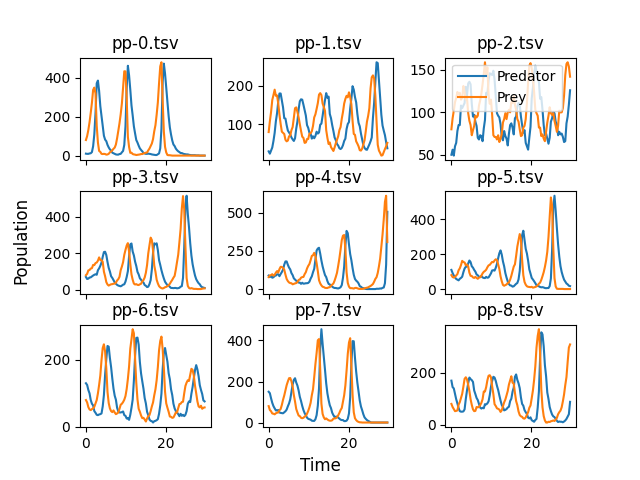

In [11]:
!rm -rf runs/pp*
!KaXim Pred-Prey.xka -t 30 -e 10000 -p 100 -d runs -o pp -r 9 --params {pred_feed} {prey_rep} {pred_die}
%matplotlib notebook
kappa.plot_files(filter = "runs/pp*",share_xy = ["col",False],subplot_name = "");